# Watershed Algorithm: Marker-Dased Image Segmentation

---
### Imports and Helper-functions

In [1]:
import os
import random

import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def imshow(img, title=None, size=10, axis=False, color_space="BGR"):
    aspect_ratio = img.shape[0] / img.shape[1]
    plt.figure(figsize=(size * aspect_ratio, size))
    if color_space.lower() == "bgr":
        rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    elif color_space.lower() == "rgb":
        rgb_img = img
    else:
        rgb_img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
    plt.imshow(rgb_img)
    if type(title) == str:
        plt.title(title)
    if axis == False:
        plt.axis('off')
    plt.show()

In [14]:
def get_random_img_path(search_path='../../res/img', skip=["flickr"]):
    """
    This function searches for common image files in all subdirectories
    and return a random image path of them.
    """
    image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff', '.ico']
    image_paths = []

    # Walk through all subdirectories
    for root, dirs, files in os.walk(search_path):
        for file_name in files:
            # Check if the file is an image
            if any(file_name.lower().endswith(ext) for ext in image_extensions):
                # Get the full file path
                full_path = os.path.join(root, file_name).replace("\\", "/")
                if not any(i in full_path for i in skip):
                    image_paths.append(full_path)

    return random.choice(image_paths)

# get an image
IMG_PATH = get_random_img_path(skip=["flickr", "weather", "gem"])
IMG_PATH   

'../../res/img/chinese_art/Dataset/Chu_Chu/Chu_Chu_01.jpg'

---
### Loading data

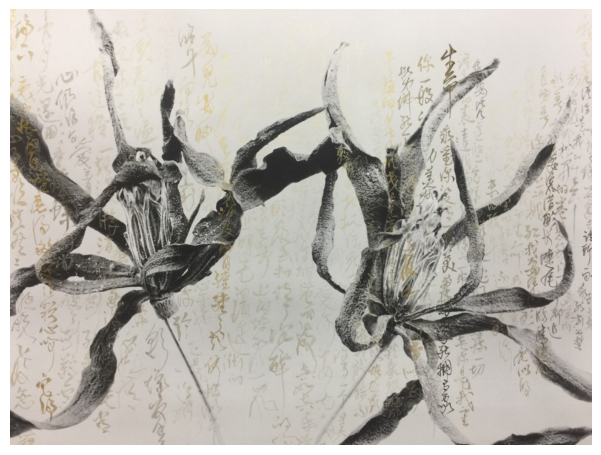

(720, 960, 3)

In [15]:
img = cv2.imread(IMG_PATH)
imshow(img)

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

img.shape

That is a bad example. But the code is the same.

---
### Watershed Algorithm

Any grayscale image can be viewed as a topographic surface where high intensity denotes peaks and hills while low intensity denotes valleys. 

This algorithm uses that analogy and starts filling those low points (valleys) with a different colored label (aka our water). 

As the water rises, depending on the peaks (gradients) nearby, water from different valleys, obviously with different colors will start to merge. To avoid that, you build barriers in the locations where water merges. You continue the work of filling water and building barriers until all the peaks are under water. 

The barriers you created gives you the segmentation result. This is the "philosophy" behind the watershed. You can visit the [CMM webpage](http://cmm.ensmp.fr/~beucher/wtshed.html) on watershed to understand it with the help of some animations.

Their approach however, gives you oversegmented result due to noise or any other irregularities in the image. 

Thus, OpenCV implemented a marker-based watershed algorithm where you specify which are all valley points are to be merged and which are not. It gives different labels for our object we know. Label the region which we are sure of being the foreground or object with one color (or intensity), label the region which we are sure of being background or non-object with another color and finally the region which we are not sure of anything, label it with 0. That is our marker. Then apply watershed algorithm. Then our marker will be updated with the labels we gave, and the boundaries of objects will have a value of -1.

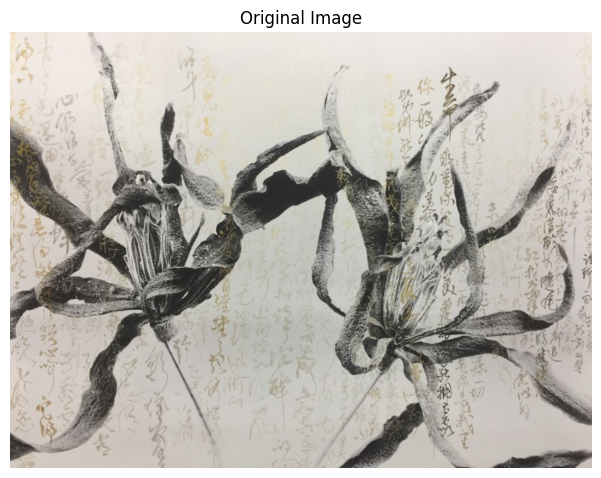

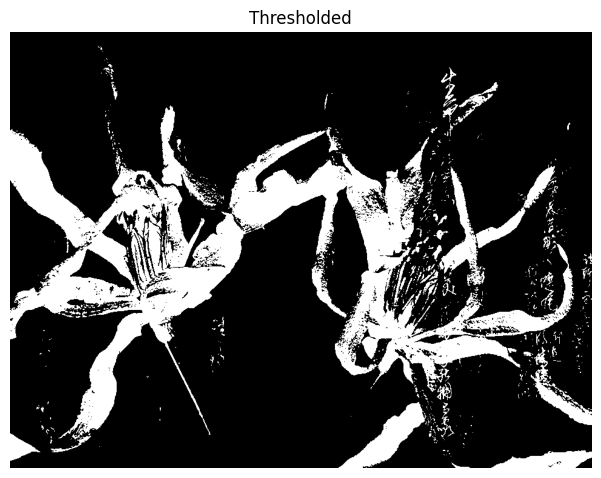

In [16]:
imshow(img, "Original Image")

ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

imshow(thresh, "Thresholded")

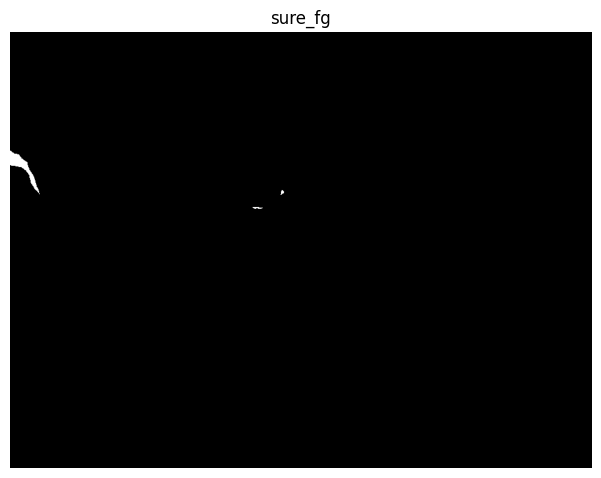

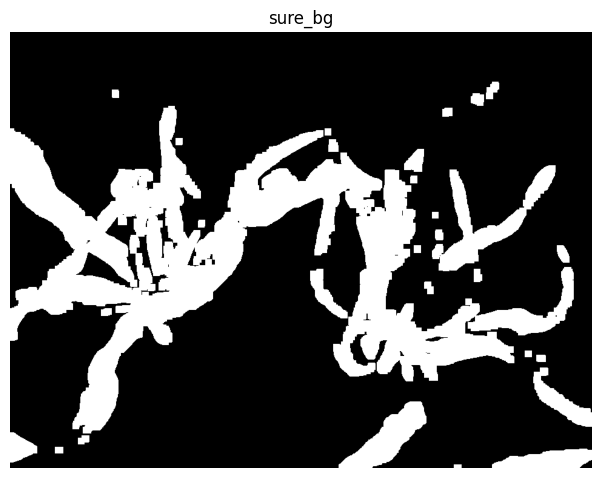

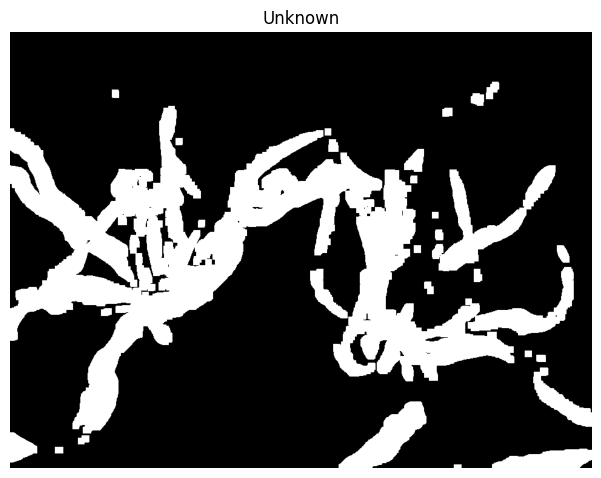

In [19]:
kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

# sure background area
sure_bg = cv2.dilate(opening, kernel, iterations=3)

# find sure foreground area
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.7*dist_transform.max(), 255, 0)
sure_fg = np.uint8(sure_fg)

# unkown region
unknown = cv2.subtract(sure_bg, sure_fg)

imshow(sure_fg, "sure_fg")
imshow(sure_bg, "sure_bg")
imshow(unknown, "Unknown")

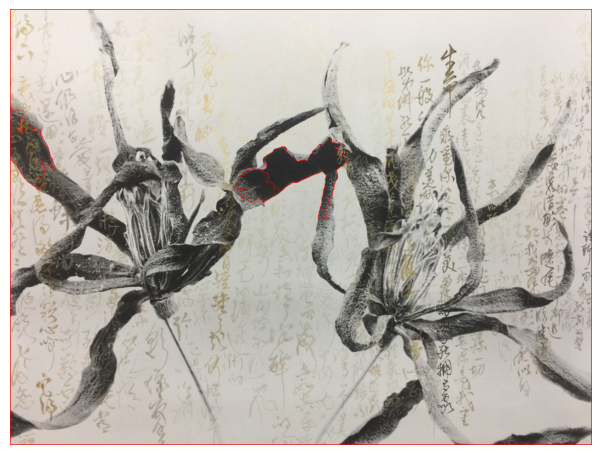

In [21]:
ret, markers = cv2.connectedComponents(sure_fg)

markers += 1

markers[unknown==255] = 0

markers = cv2.watershed(img, markers)
img[markers == -1] = [0, 0, 255]

imshow(img)

---